In [1]:
import sys
sys.path.insert(0, '../../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from preprocess import Audio_Processor
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0#int(orig_SR)

SR = 16000
blocksize = int(SR * 5)
overlap = 0#int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../../ESC-50/audio/'

In [5]:
path_to_db='../../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=True
                       )

In [11]:
df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_mean,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target
0,45.116146,39.160271,27.011630,20.044099,13.047446,9.788639,6.934971,6.707770,6.888817,6.466031,...,-1.295722e-09,1.909698e-09,1.069887e-10,32.402931,45.972459,6.189134,35.834585,0.515079,0,0
1,65.339622,75.485049,56.207152,50.475587,64.285497,70.515282,60.320153,46.373598,49.737434,57.091641,...,-2.287257e-02,5.705404e-02,-1.560596e-03,12.664339,15.564616,5.078091,16.335999,3.762399,0,14
2,43.061324,46.182001,40.106757,40.136323,40.897473,42.706223,41.896956,41.832416,40.980207,42.695909,...,-3.775094e-02,-3.840658e-02,4.158728e-03,12.226533,23.890379,5.205682,20.391980,2.567054,1,36
3,41.310758,43.261874,42.021508,42.038297,39.631103,44.909130,41.440406,41.647823,44.932650,43.031895,...,-6.988263e-03,-6.869134e-04,-1.677152e-02,12.410390,22.183133,5.045153,19.136592,2.779194,1,36
4,100.620789,53.510768,55.781926,47.936314,45.258422,42.265947,39.135615,37.709452,40.700650,38.318367,...,-2.368598e-02,-1.520506e-02,2.918289e-03,10.353268,21.252477,5.696141,19.865682,2.614596,1,19


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [12]:
import time
import librosa
import numpy as np
import soundfile as sf

# Lowpass Filter
import scipy.signal as signal

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [13]:
c_data_test, target = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)
print(c_data_test.shape)

	Processing Time: 61.98859000205994
(400, 1, 80000)


In [14]:
c_data_train, target = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)
print(c_data_train.shape)

	Processing Time: 243.4339964389801
(1600, 1, 80000)


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_X = scaler.fit_transform(df[400:].drop(['target', 'h_target'], axis=1).values)
train_y = df[400:]['h_target'].values

test_X = scaler.transform(df[:400].drop(['target', 'h_target'], axis=1).values)
test_y = df[:400]['h_target'].values

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input, Concatenate, concatenate
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 50
batch = 50

def gpu_mfcc_shallow_net():
    # Create Model
    
    cnn = Input(shape=(1,blocksize))
    cnn_mel = Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    )(cnn)
    cnn_conv = Convolution2D(32, 3, 3, name='conv1', activation='relu')(cnn_mel)
    cnn_pool = MaxPooling2D((25, 17))(cnn_conv)
    cnn_flat = Flatten()(cnn_pool)
    cnn_dense = Dense(32, activation='relu')(cnn_flat)
    
    pre_comp = Input(shape=(129,))
    pre_dense = Dense(100,)(pre_comp)
    
    merged = concatenate([cnn_dense, pre_dense])
    
    merged = Dense(32, activation='relu')(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dropout(0.2)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dropout(0.2)(merged)
    merged = Dense(1, kernel_initializer='normal', activation='sigmoid')(merged)

    model = Model(inputs=[cnn, pre_comp], outputs=merged)
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [17]:
model = gpu_mfcc_shallow_net()
history = model.fit([c_data_train, train_X], 
          train_y,
          batch_size=batch,
          nb_epoch=epochs,
          validation_split=0.1
         )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 80000)     0                                            
__________________________________________________________________________________________________
melspectrogram_1 (Melspectrogra (None, 128, 313, 1)  296064      input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 126, 311, 32) 320         melspectrogram_1[0][0]           
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 5, 18, 32)    0           conv1[0][0]                      
__________________________________________________________________________________________________
flatten_1 

1440/1440 [==============================] - 13s 9ms/step - loss: 0.1045 - acc: 0.9597 - mean_absolute_error: 0.0631 - val_loss: 0.7573 - val_acc: 0.8250 - val_mean_absolute_error: 0.1986
Epoch 24/50
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0860 - acc: 0.9646 - mean_absolute_error: 0.0507 - val_loss: 0.7542 - val_acc: 0.8063 - val_mean_absolute_error: 0.2103
Epoch 25/50
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0834 - acc: 0.9674 - mean_absolute_error: 0.0532 - val_loss: 0.8897 - val_acc: 0.8188 - val_mean_absolute_error: 0.1922
Epoch 26/50
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0639 - acc: 0.9771 - mean_absolute_error: 0.0370 - val_loss: 0.8917 - val_acc: 0.8125 - val_mean_absolute_error: 0.1993
Epoch 27/50
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0650 - acc: 0.9771 - mean_absolute_error: 0.0358 - val_loss: 1.0889 - val_acc: 0.8250 - val_mean_absolute_error: 0.1903
Epoch 28/50


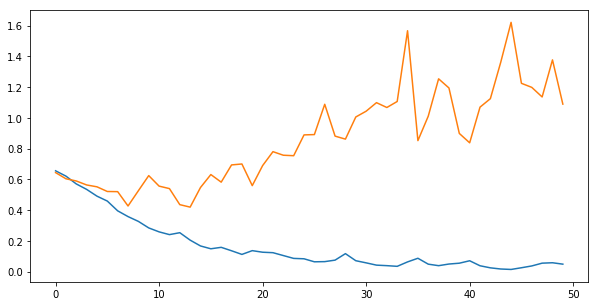

In [18]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

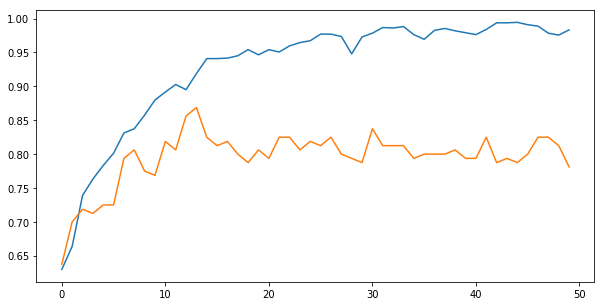

In [19]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [20]:
model.metrics_names

['loss', 'acc', 'mean_absolute_error']

In [21]:
model.evaluate(x=[c_data_test,test_X], y=test_y)

400/400 [==============================] - 2s 4ms/step


[1.3744562005996703, 0.75, 0.24896447360515594]

0.36
Confusion matrix, without normalization
[[144   0]
 [256   0]]


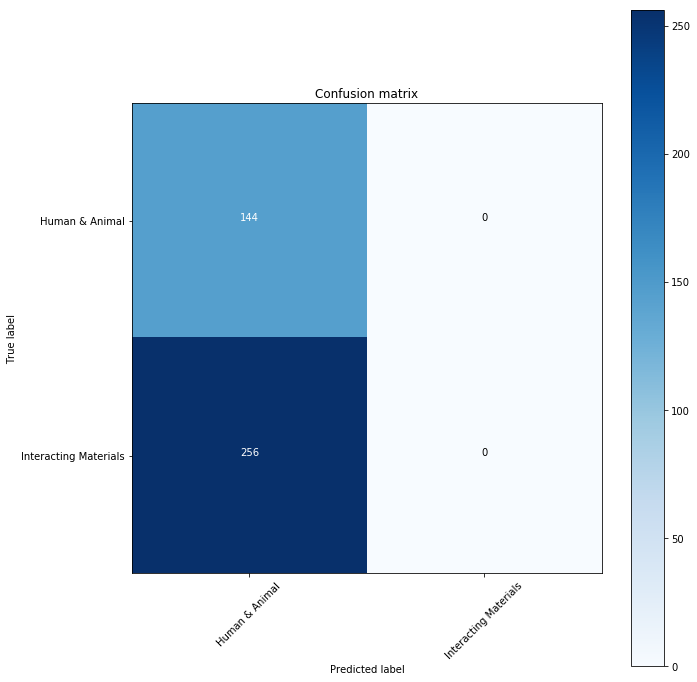

In [22]:
pred = model.predict([c_data_test,test_X])
pred = pred.argmax(axis=-1)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [23]:
import seaborn as sns
misclassified = {
    'Predicted h_target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

correctly_classified = {
    'Predicted h_target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

for p, prob, Y in zip(pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
    else:
        correctly_classified['Predicted h_target'].append(h_classes[p])
        correctly_classified['Anim_prob'].append(prob[0])
        correctly_classified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
correctly_classified = pd.DataFrame.from_dict(correctly_classified)

NameError: name 'pred_prob' is not defined

In [ ]:
average_prob = misclassified.groupby('Predicted h_target').mean()
average_prob.head()

In [ ]:
average_prob = correctly_classified.groupby('Predicted h_target').mean()
average_prob.head()